In [2]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

dl = DataLib("SignalData")

In [44]:
'''
takes in indicator. Then processes return and plots bond return, indicator, and pnl
indicator is a function, returns new time series with the indicator

CURRENTLY ONLY DOING FOR USA
'''
bond_return_index = dl.pull('BondRetIdx/LocalFX')
bond_return_change = bond_return_index.resample('M').mean().pct_change()


def evaluate_performance(indicator):
    shifted_bond_return = bond_return_change.shift(1)
    days_profit = shifted_bond_return['USA'] * indicator
    pnl = days_profit.cumsum()
    pnl = pnl * 100
    position = indicator.shift(1)
    return position, pnl
    
    
def plot_evaluation(indicator, pnl, position):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(pnl.to_timestamp(), label = 'Portfolio Returns')
    ax1.plot(bond_return_index['USA'].to_timestamp(), label = 'Bond Market Index')
    ax1.set_ylabel('Returns or Index')
    ax1.legend()
    ax2.plot(indicator.to_timestamp(), color = 'tab:red',label = 'Indicator')
    ax2.set_ylabel('Indicator')
    ax2.legend()
    plt.title('USA')
    plt.show()


# Curve Height

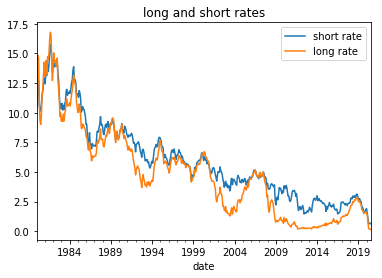

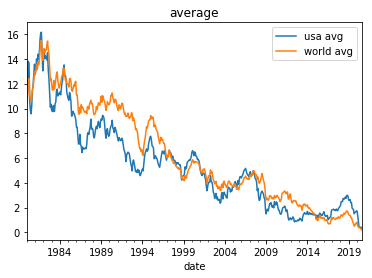

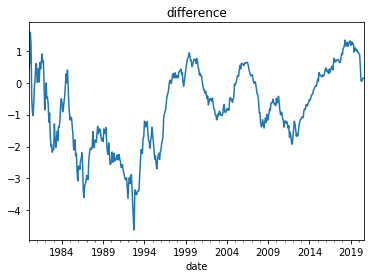

In [32]:
'''
indicator to look at curve height
'''
curve_height_indicator = pd.Series([])
short_rates = dl.pull('LongRates')
long_rates = dl.pull('ShortRates')
average_long_and_short = (long_rates + short_rates) / 2
average_long_and_short = average_long_and_short.drop(['JPN', 'CHE', 'DEU'], axis=1)
world_average = average_long_and_short.mean(axis = 1)

short_rates['USA'].plot()
long_rates['USA'].plot()
plt.title('long and short rates')
plt.legend(['short rate', 'long rate'])
plt.show()

average_long_and_short['USA'].plot()
world_average.plot()
plt.legend(['usa avg', 'world avg'])
plt.title('average')
plt.show()

diff_usa_vs_world_avg = average_long_and_short['USA'] - world_average
diff_usa_vs_world_avg.plot()
plt.title('difference')
plt.show()


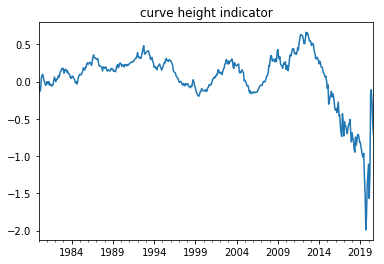

In [47]:
for date in diff_usa_vs_world_avg.index:
    curve_height_indicator.loc[date] = -diff_usa_vs_world_avg[date]/world_average[date]

curve_height_indicator.plot()
plt.title('curve height indicator')
plt.show()

Includes: difference, world average (difference of 1 when world average is 1 could be more significant)

Problems: never very long or short (usually stays between [-0.5, 0.5] because the average is not gonna get that high. also, the numbers get too big when the averages are so low toward the end.




### Testing Various Lags


indicator : lag =  0


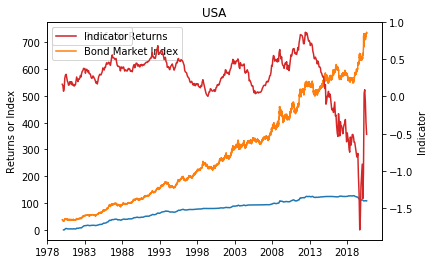

max:  127.21764514253576
min:  -0.6541559534686788
-----------------------------------------

indicator : lag =  1


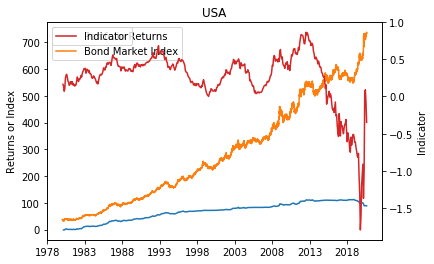

max:  112.45176601158123
min:  -1.1872241424021392
-----------------------------------------

indicator : lag =  2


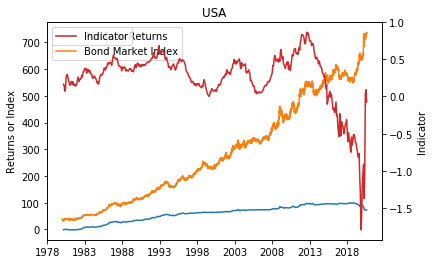

max:  99.084498842003
min:  -2.03960765068877
-----------------------------------------

indicator : lag =  3


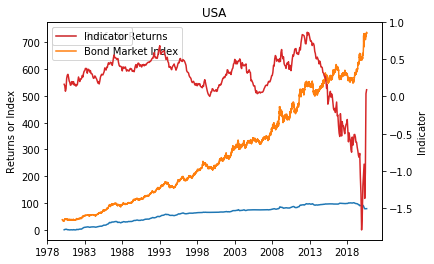

max:  100.9290848526629
min:  -0.642679281285325
-----------------------------------------

indicator : lag =  6


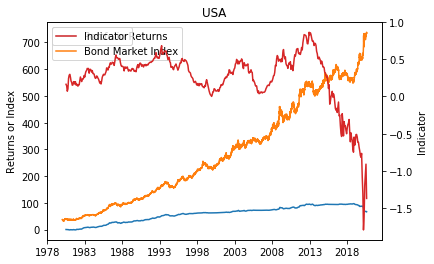

max:  97.14405442206629
min:  -1.0639912159257037
-----------------------------------------

indicator : lag =  9


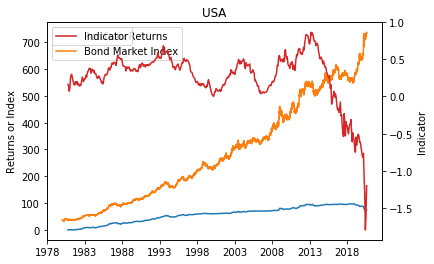

max:  97.25934232537213
min:  -0.496931511148212
-----------------------------------------

indicator : lag =  12


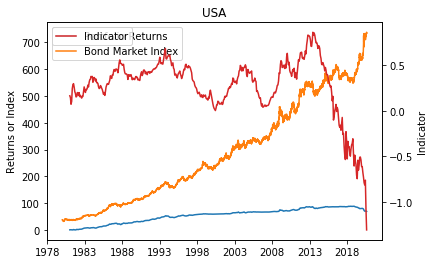

max:  88.541999358892
min:  -0.14138543874848514
-----------------------------------------


In [45]:
'''
test different lags

using: curve_height_indicator
'''

for lag in [0, 1, 2, 3, 6, 9, 12]:
    print('\nindicator : lag = ', lag)
    lagged_indicator = curve_height_indicator.shift(lag)
    position, pnl = evaluate_performance(lagged_indicator)
    plot_evaluation(lagged_indicator, pnl, position)
    print('max: ', pnl.max())
    print('min: ', pnl.min())
    print('-----------------------------------------')

Adding any lag seems to decrease performance. This does logically make sense because we are predicting the way prices will function in the future and trading currently in anticipation of those changes.

### Looking at problems in data

Looking very preliminary before, my averages were being messed up due to DEU, JPN, and CHE (there seemed to be a few outliers that were much higher or lower than the others). Just diving deeper to understand what is going on.

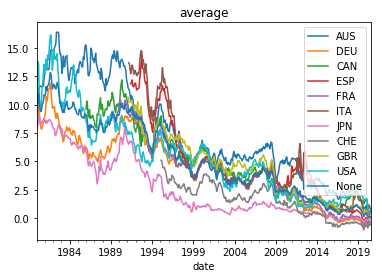

In [34]:
curve_height_indicator = pd.Series([])
short_rates = dl.pull('LongRates')
long_rates = dl.pull('ShortRates')
average_long_and_short = (long_rates + short_rates) / 2
world_average = average_long_and_short.mean(axis = 1)

average_long_and_short.plot()
world_average.plot()
plt.legend()
plt.title('average')
plt.show()

Super weird I looked at this chart and they all seemed normal enough but the indicator becomes super negative and in general the returns seem better without it. Maybe their bonds are not useful and people dont really trade their bonds as much? So if their yields are lower people will not short those bonds and similarly if the yields are high people will not long those bonds?

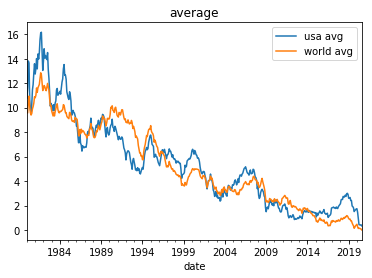

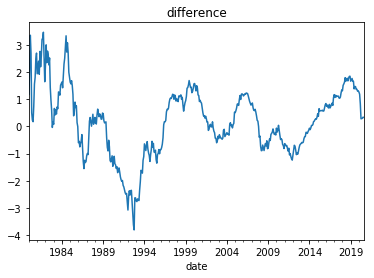

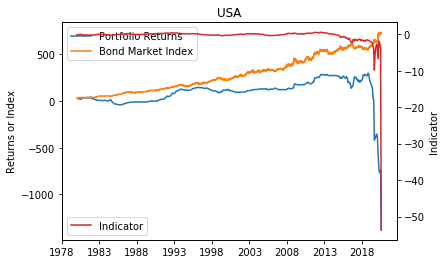

In [35]:
test_curve_height_indicator = pd.Series([])
all_average_long_and_short = (long_rates + short_rates) / 2
all_world_average = all_average_long_and_short.mean(axis = 1)

all_average_long_and_short['USA'].plot()
all_world_average.plot()
plt.legend(['usa avg', 'world avg'])
plt.title('average')
plt.show()

test_diff_usa_vs_world_avg = all_average_long_and_short['USA'] - all_world_average
test_diff_usa_vs_world_avg.plot()
plt.title('difference')
plt.show()

for date in test_diff_usa_vs_world_avg.index:
    test_curve_height_indicator.loc[date] = -test_diff_usa_vs_world_avg[date]/all_world_average[date]

position, pnl = evaluate_performance(test_curve_height_indicator)
plot_evaluation(test_curve_height_indicator, pnl, position)

## Test performance against bond market

One problem with this is I am not sure I am scaling/evaluating the pnl corretly :P

I would love to see a difference in the structure of the lines (so its not kinda just scaled)

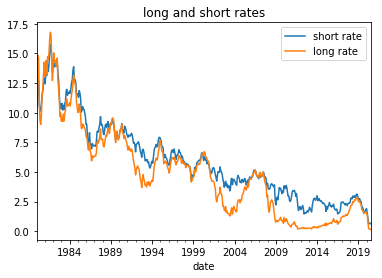

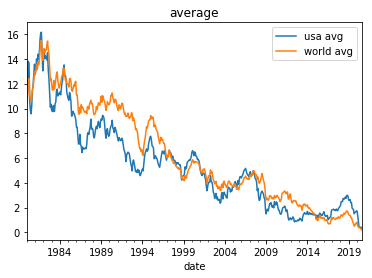

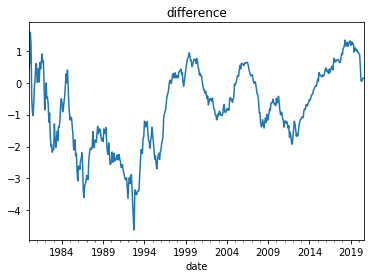

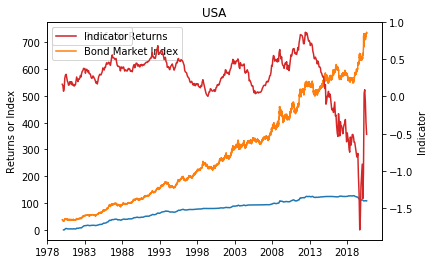

In [43]:
curve_height_indicator = pd.Series([])
short_rates = dl.pull('LongRates')
long_rates = dl.pull('ShortRates')
average_long_and_short = (long_rates + short_rates) / 2
average_long_and_short = average_long_and_short.drop(['JPN', 'CHE', 'DEU'], axis=1)
world_average = average_long_and_short.mean(axis = 1)

short_rates['USA'].plot()
long_rates['USA'].plot()
plt.title('long and short rates')
plt.legend(['short rate', 'long rate'])
plt.show()

average_long_and_short['USA'].plot()
world_average.plot()
plt.legend(['usa avg', 'world avg'])
plt.title('average')
plt.show()

diff_usa_vs_world_avg = average_long_and_short['USA'] - world_average
diff_usa_vs_world_avg.plot()
plt.title('difference')
plt.show()

for date in diff_usa_vs_world_avg.index:
    curve_height_indicator.loc[date] = -diff_usa_vs_world_avg[date]/world_average[date] + 0.2
    
position, pnl = evaluate_performance(curve_height_indicator)
plot_evaluation(curve_height_indicator, pnl, position)

There is a big difference at the end. The indicator is dramatically going downward but returns are increasing so this may be bad. Potentially I can look into an indicator that would explain this difference to compliment the curve height indicator. Also, the value becomes so negative because the world average is so low, and I am dividing byt he world average.